This notebook shows the code produced to refine the PTB Diagnostic ECG database to provide a smaller subset of the database for which analysis can take place on.

The data has been filtered based on these factors: 
 - at least ? minutes worth of recording (will cut all files to the first two minutes)
 - access to meta data
 - removed repeated ECGs from the same patient as this could skew results down the line
 
 In addition to this the data that will be kept will only consist of the V1-V6 channels because...

In [207]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [64]:
patients = wfdb.get_record_list('ptbdb') #creates a list containing the directories of all the ECGs within the data base

print('Number of ECGs within the database: ', len(patients))

Number of ECGs within the database:  549


As we can see from above there are 549 total ECGs within the unfiltered database, these will then be filtered below into the list of *allowed_patients*.

Creating a class to include the desired information for each patient, with relevant getter and setter functions.

In [303]:
class Patient:
    def __init__(self, name, age, gender, health_state, diagnosis, smoker):
        self._name = str
        self._age = int
        self._gender = str
        self._health_state = str
        self._diagnosis = str
        self._smoker = str
        self._ecg_data = None

    def set_name(self, name):
        self._name = name
        
    def set_health_state(self, health_state):
        self._health_state = health_state

    def set_diagnosis(self, diagnosis):
        self._diagnosis = diagnosis

    def set_ecg_data(self, ecg_data):
        self._ecg_data = ecg_data

    def set_age(self, age):
        self._age = age
        
    def set_gender(self, gender):
        self._gender = gender
    
    def set_smoker_status(self, smoker):
        self._smoker = smoker
        
    def get_name(self):
        return self._name
    
    def get_age(self):
        return self._age
    
    def get_gender(self):
        return self._gender
    
    def get_smoker_status(self):
        return self._smoker
    
    def get_ecg_data(self):
        return self._ecg_data
    
    def get_diagnosis(self):
        return self._diagnosis   
    
    def get_health_state(self):
        return self._health_state
    
    def get_info(self):
        info = f"Name: {self._name} \n Age: {self._age}\n Gender: {self._gender}\n"
        info += f"Health State: {self._health_state}\nDiagnosis: {self._diagnosis}\n"
        info += f"ECG Data: {self._ecg_data} \nSmoker: {self._smoker}"
        return info
    
    def plot_ecg(self):
        wfdb.plot_wfdb(record=self.get_ecg_data(), title='Example Signals, '+ self._name)

Creating a class to contain a list of all allowed patients

In [347]:
class PatientCollection:
    def __init__(self):
        self._patients = []
        self._diagnosis_list = ['Myocardial infarction', 'Healthy control', 'Dysrhythmia', 'Cardiomyopathy', 'Hypertrophy', 'Bundle branch block', 'Valvular heart disease', 'Stable angina', 'Myocarditis']


    def add_patient(self, patient):
        self._patients.append(patient)
        
    def get_patient(self, indx):
        return self._patients[indx]
    
    def get_records(self):
        return [patient.get_ecg_data() for patient in self._patients]
    
    def count_patients(self):
        return len(self._patients)

    def get_all_info(self):
        return [patient.get_info() for patient in self._patients]

    def count_smokers(self):
        return sum(1 for patient in self._patients if patient._smoker == 'yes')
    
    def count_healthy(self):
        return sum(1 for patient in self._patients if patient._health_state == 'Healthy')
    
    def count_unhealthy(self):
        return sum(1 for patient in self._patients if patient._health_state == 'Unhealthy')
    
    def count_gender(self):
        return sum(1 for patient in self._patients if patient._gender == 'Male')
    
    def get_diagnosis_list(self):
        return self._diagnosis_list
    
    def get_diagnosis_counts(self):
        diagnoses = [patient._diagnosis for patient in self._patients] #creates list of each diagnosis within the patients in the list
        diagnosis_counts = {diagnosis: diagnoses.count(diagnosis) for diagnosis in set(diagnoses)} #counts each diagnosis, set()removes repeats
        return diagnosis_counts
    
    def plot_diagnosis(self):
        diagnosis_counts = self.get_diagnosis_counts()
        fig, axes = plt.subplots(1, 1, figsize = (12, 10))
        
        axes.bar(diagnosis_counts.keys(), diagnosis_counts.values())
        axes.set_xlabel('Diagnosis')
        axes.set_ylabel('Count')
        axes.set_title('Diagnosis Distribution')
        axes.legend([f"Total Number of People: {self.count_patients()}, Healthy: {self.count_healthy()}", f"Unhealthy: {self.count_unhealthy()}"])
        plt.show()
        
    def plot_sample_ecg(self):
        plot_indx = np.random.randint(0, self.count_patients())
        patient = self.get_patient(plot_indx)
        patient.plot_ecg()
        
        


In [348]:
channel_names = ["v1", "v2", "v3", "v4", "v5", "v6"]

age_meta_idx = 0
smoking_meta_idx = 8
gender_meta_idx = 1
diagnosis_meta_idx = 4
previous_label = 'n/a'

#definite application
duplicate_data_filtering = True
desired_sample_length = 60000


age_data_filtering = False
smoking_data_filtering = False #smoking filter gets rid of alot of healthy patients -leaves only 3 remaining
gender_data_filtering = False

#156 people and 3 healthy if all filters applied

allowed_patients = PatientCollection()

for i in range(0, len(patients)):
    #creating new patient instance
    new_Patient = Patient(None, None, None, None, None, None)
    
    #setting bool to true unless conditions for appending is not met
    append = True
    
    #try and except clause to ensure only ECGs longer than the minimum length are kept
    try:
        record = wfdb.rdrecord('ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/' + patients[i], channel_names = channel_names, sampto = desired_sample_length)
        #append ECG data to Patient instance
        new_Patient.set_ecg_data(record)
        
        #labelling the diagnosis within the class
        if record.comments[diagnosis_meta_idx][22:] not in allowed_patients.get_diagnosis_list():
            append = False
        else:
            new_Patient.set_diagnosis(record.comments[diagnosis_meta_idx][22:])
            
        #labelling the health state of each patient class
        if record.comments[diagnosis_meta_idx][22:] == 'Healthy control':
            new_Patient.set_health_state('Healthy')
        else:
            new_Patient.set_health_state('Unhealthy')
        
        if age_data_filtering:
            #making sure age meta data is available
            if record.comments[age_meta_idx] == None:
                append = False
            else:
                new_Patient.set_age(int(record.comments[age_meta_idx][5:]))
                
        if smoking_data_filtering:
            #ensuring smoking meta data is available
            print(record.comments[smoking_meta_idx][8:])
            if record.comments[smoking_meta_idx][8:] not in ('yes', 'no'):
                append = False
            else:
                new_Patient.set_smoker_status(record.comments[smoking_meta_idx][8:])
                
        if gender_data_filtering:
            #ensuring gender meta data is available
            if record.comments[gender_meta_idx][5:] not in ('male', 'female'):
                append = False
            else:
                new_Patient.set_gender(record.comments[gender_meta_idx][5:])
            
        if duplicate_data_filtering:
            #only appending the first ECG from each patient to remove duplicates
            patient_number = patients[i][:10]
            if patient_number == previous_label:
                append = False
            else:
                previous_label = patient_number
                new_Patient.set_name(patients[i][:10])
                    
        if append:
            allowed_patients.add_patient(new_Patient)
        
    except ValueError as ve:
        None
        #print(f"Error reading record for patient {patients[i]}: {ve}")


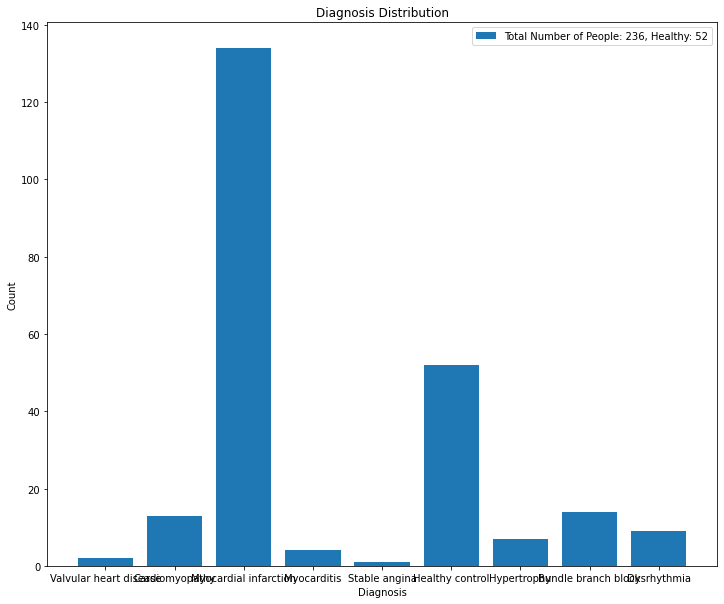

In [349]:
allowed_patients.plot_diagnosis()

In [350]:
#possibly group least common illnesses into 'other' group
#plot the distributions of meta data within the database
#include everything within the classes??

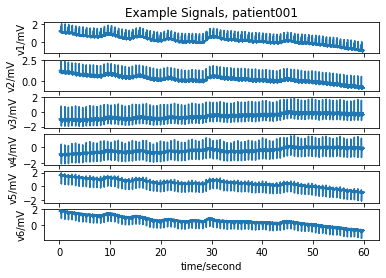

In [351]:
patient1 = allowed_patients.get_patient(0)
patient1.plot_ecg()


Applying the above filters, roughly halves the amount of ECGs in the database.

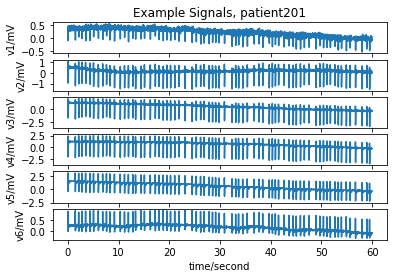

In [352]:
allowed_patients.plot_sample_ecg()

In [353]:
records = allowed_patients.get_records()


In [354]:
#have access to all the record objects within the filtered database now need to see how actually want to filter the data

[<wfdb.io.record.Record object at 0x0000018F408DA7F0>, <wfdb.io.record.Record object at 0x0000018ECB13D790>, <wfdb.io.record.Record object at 0x0000018E98551940>, <wfdb.io.record.Record object at 0x0000018E98551670>, <wfdb.io.record.Record object at 0x0000018E98551790>, <wfdb.io.record.Record object at 0x0000018E98551A30>, <wfdb.io.record.Record object at 0x0000018E985512E0>, <wfdb.io.record.Record object at 0x0000018ECB1827F0>, <wfdb.io.record.Record object at 0x0000018ECB182550>, <wfdb.io.record.Record object at 0x0000018ECB182070>, <wfdb.io.record.Record object at 0x0000018ECB1829A0>, <wfdb.io.record.Record object at 0x0000018ECB182C40>, <wfdb.io.record.Record object at 0x0000018ECB182D30>, <wfdb.io.record.Record object at 0x0000018ECB1822E0>, <wfdb.io.record.Record object at 0x0000018ECB182160>, <wfdb.io.record.Record object at 0x0000018ECB182BB0>, <wfdb.io.record.Record object at 0x0000018ECB1823D0>, <wfdb.io.record.Record object at 0x0000018ECB182430>, <wfdb.io.record.Record obje